Автомобильный рынок в США всегда был индикатором экономического здоровья страны, где на автомобилях ездят практически все – от детишек до старушек. Автомобиль для американца – это в какой-то степени часть его самого, ведь без этого транспортного средства в такой огромной стране, где далеко не везде ходит общественный транспорт, зачастую просто не выжить.

В мои руки попал набор данных по продажам на авто рынках Америки. В своей работе я бы хотел провести анализ этой информации и выявить на их основе некоторые тенденции.

In [1]:
#Импортирую библиотеки
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import fuzzywuzzy
from fuzzywuzzy import process
import scipy
from scipy import stats
from scipy.stats import linregress

%matplotlib inline

In [2]:
def replace_matches_in_column(df, column, string_to_match, min_ratio):
    """Функция для очистки качественных данных. 
  
    """
    #Получаю список уникальных строк
    strings = df[column].unique()
    
    #Получаю 10 самых близких совпадений 
    matches = fuzzywuzzy.process.extract(string_to_match, strings, 
                                         limit=10, scorer=fuzzywuzzy.fuzz.token_sort_ratio)

    #Только матчи, в которых ratio > 90
    close_matches = [matches[0] for matches in matches if matches[1] >= min_ratio]

    #Получаю строчки всех ближайших матчей с вводными 
    rows_with_matches = df[column].isin(close_matches)

    #Меняю все строки 
    df.loc[rows_with_matches, column] = string_to_match
   


In [3]:
data = pd.read_csv(r'../Датасеты/car_prices.csv',nrows=400000)

In [4]:
data.head()

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate
0,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg566472,ca,5.0,16639.0,white,black,"kia motors america, inc",20500,21500,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
1,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg561319,ca,5.0,9393.0,white,beige,"kia motors america, inc",20800,21500,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
2,2014,BMW,3 Series,328i SULEV,Sedan,automatic,wba3c1c51ek116351,ca,4.5,1331.0,gray,black,financial services remarketing (lease),31900,30000,Thu Jan 15 2015 04:30:00 GMT-0800 (PST)
3,2015,Volvo,S60,T5,Sedan,automatic,yv1612tb4f1310987,ca,4.1,14282.0,white,black,volvo na rep/world omni,27500,27750,Thu Jan 29 2015 04:30:00 GMT-0800 (PST)
4,2014,BMW,6 Series Gran Coupe,650i,Sedan,automatic,wba6b2c57ed129731,ca,4.3,2641.0,gray,black,financial services remarketing (lease),66000,67000,Thu Dec 18 2014 12:30:00 GMT-0800 (PST)


In [5]:
data.shape

(400000, 16)

In [6]:
data.describe()

,year,condition,odometer,mmr,sellingprice
count,400000.000000,388207.000000,399914.000000,400000.000000,400000.000000
mean,2009.796108,3.410007,70519.600534,13323.868750,13187.522913
std,4.042418,0.961237,54530.181852,9383.886206,9472.330671
min,1982.000000,1.000000,1.000000,25.000000,1.000000
25%,2007.000000,2.700000,28894.000000,6550.000000,6300.000000
50%,2011.000000,3.600000,54863.000000,12000.000000,11900.000000
75%,2013.000000,4.200000,102903.750000,17850.000000,17800.000000
max,2015.000000,5.000000,999999.000000,176000.000000,230000.000000


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400000 entries, 0 to 399999
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          400000 non-null  int64  
 1   make          392910 non-null  object 
 2   model         392844 non-null  object 
 3   trim          392581 non-null  object 
 4   body          390037 non-null  object 
 5   transmission  355878 non-null  object 
 6   vin           400000 non-null  object 
 7   state         400000 non-null  object 
 8   condition     388207 non-null  float64
 9   odometer      399914 non-null  float64
 10  color         399447 non-null  object 
 11  interior      399447 non-null  object 
 12  seller        400000 non-null  object 
 13  mmr           400000 non-null  int64  
 14  sellingprice  400000 non-null  int64  
 15  saledate      400000 non-null  object 
dtypes: float64(2), int64(3), object(11)
memory usage: 48.8+ MB


Неправильный тип у даты. Чуть попозже поменяю его

In [8]:
data.isnull().sum()

year                0
make             7090
model            7156
trim             7419
body             9963
transmission    44122
vin                 0
state               0
condition       11793
odometer           86
color             553
interior          553
seller              0
mmr                 0
sellingprice        0
saledate            0
dtype: int64

Довольно много пропущенных значений. Заменю нуллы качественных данных на 'N', а количественных на 0

In [9]:
#Заполняю 0 в количественных и "N" в качественных данных
data = data.fillna({'condition': 0, 'odometer': 0, 'mmr':0, 'sellingprice':0, 'year': 'N', 'make': 'N', 'model': 'N', 'trim': 'N', 'body': 'N', 'transmission': 'N', 'vin': 'N', 'state' : 'N', 'color' : 'N', 'interior': 'N', 'seller': 'N', 'saledate' : 'N'})

#Копирую данные
data1 = data.copy()

In [10]:
data1.isnull().sum()

year            0
make            0
model           0
trim            0
body            0
transmission    0
vin             0
state           0
condition       0
odometer        0
color           0
interior        0
seller          0
mmr             0
sellingprice    0
saledate        0
dtype: int64

Теперь пропущенных значений нет

In [11]:
data1.head()

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate
0,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg566472,ca,5.0,16639.0,white,black,"kia motors america, inc",20500,21500,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
1,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg561319,ca,5.0,9393.0,white,beige,"kia motors america, inc",20800,21500,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
2,2014,BMW,3 Series,328i SULEV,Sedan,automatic,wba3c1c51ek116351,ca,4.5,1331.0,gray,black,financial services remarketing (lease),31900,30000,Thu Jan 15 2015 04:30:00 GMT-0800 (PST)
3,2015,Volvo,S60,T5,Sedan,automatic,yv1612tb4f1310987,ca,4.1,14282.0,white,black,volvo na rep/world omni,27500,27750,Thu Jan 29 2015 04:30:00 GMT-0800 (PST)
4,2014,BMW,6 Series Gran Coupe,650i,Sedan,automatic,wba6b2c57ed129731,ca,4.3,2641.0,gray,black,financial services remarketing (lease),66000,67000,Thu Dec 18 2014 12:30:00 GMT-0800 (PST)


In [12]:
data1.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400000 entries, 0 to 399999
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          400000 non-null  int64  
 1   make          400000 non-null  object 
 2   model         400000 non-null  object 
 3   trim          400000 non-null  object 
 4   body          400000 non-null  object 
 5   transmission  400000 non-null  object 
 6   vin           400000 non-null  object 
 7   state         400000 non-null  object 
 8   condition     400000 non-null  float64
 9   odometer      400000 non-null  float64
 10  color         400000 non-null  object 
 11  interior      400000 non-null  object 
 12  seller        400000 non-null  object 
 13  mmr           400000 non-null  int64  
 14  sellingprice  400000 non-null  int64  
 15  saledate      400000 non-null  object 
dtypes: float64(2), int64(3), object(11)
memory usage: 48.8+ MB


In [13]:
#Меняю формат даты на нужный
data1['date_parsed'] = pd.to_datetime(data1['saledate'], format = '%m/%d/%y',infer_datetime_format=True)

In [14]:
data1.head()

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate,date_parsed
0,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg566472,ca,5.0,16639.0,white,black,"kia motors america, inc",20500,21500,Tue Dec 16 2014 12:30:00 GMT-0800 (PST),2014-12-16 12:30:00+08:00
1,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg561319,ca,5.0,9393.0,white,beige,"kia motors america, inc",20800,21500,Tue Dec 16 2014 12:30:00 GMT-0800 (PST),2014-12-16 12:30:00+08:00
2,2014,BMW,3 Series,328i SULEV,Sedan,automatic,wba3c1c51ek116351,ca,4.5,1331.0,gray,black,financial services remarketing (lease),31900,30000,Thu Jan 15 2015 04:30:00 GMT-0800 (PST),2015-01-15 04:30:00+08:00
3,2015,Volvo,S60,T5,Sedan,automatic,yv1612tb4f1310987,ca,4.1,14282.0,white,black,volvo na rep/world omni,27500,27750,Thu Jan 29 2015 04:30:00 GMT-0800 (PST),2015-01-29 04:30:00+08:00
4,2014,BMW,6 Series Gran Coupe,650i,Sedan,automatic,wba6b2c57ed129731,ca,4.3,2641.0,gray,black,financial services remarketing (lease),66000,67000,Thu Dec 18 2014 12:30:00 GMT-0800 (PST),2014-12-18 12:30:00+08:00


In [15]:
data1.make.unique()

array(['Kia', 'BMW', 'Volvo', 'Nissan', 'Chevrolet', 'Audi', 'Ford',
       'Hyundai', 'Buick', 'Cadillac', 'Acura', 'Lexus', 'Infiniti',
       'Jeep', 'Mercedes-Benz', 'Mitsubishi', 'Mazda', 'MINI',
       'Land Rover', 'Lincoln', 'lincoln', 'Jaguar', 'Volkswagen',
       'Toyota', 'Subaru', 'Scion', 'Porsche', 'N', 'bmw', 'Dodge',
       'FIAT', 'Chrysler', 'ford', 'Ferrari', 'Honda', 'GMC',
       'mitsubishi', 'Ram', 'smart', 'chevrolet', 'Bentley', 'chrysler',
       'pontiac', 'Pontiac', 'Saturn', 'Maserati', 'Mercury', 'HUMMER',
       'landrover', 'cadillac', 'land rover', 'mercedes', 'mazda',
       'toyota', 'lexus', 'gmc truck', 'honda', 'nissan', 'porsche',
       'Saab', 'Suzuki', 'dodge', 'subaru', 'Oldsmobile', 'oldsmobile',
       'hyundai', 'jeep', 'Isuzu', 'dodge tk', 'Geo', 'acura',
       'volkswagen', 'suzuki', 'kia', 'audi', 'Rolls-Royce', 'gmc',
       'maserati', 'mazda tk', 'mercury', 'buick', 'hyundai tk',
       'mercedes-b', 'vw', 'Daewoo', 'chev truck', 'f

В колонке "make" довольно много дубликатов. Например, тут есть "ford" и 'ford tk', 'Chevrolet' и 'chev truck', и т.д. Нужно это исправить

In [16]:
data1.make = data1.make.str.lower()

In [17]:
#При помощи ф-ции, функционал которой уже был расписан, меняю совпадения на входные данные. 
replace_matches_in_column(df = data1, column = 'make', string_to_match = 'gmc',min_ratio = 50)
replace_matches_in_column(df = data1, column = 'make', string_to_match = 'mercedes',min_ratio = 76)
replace_matches_in_column(df = data1, column = 'make', string_to_match = 'dodge',min_ratio = 77)
replace_matches_in_column(df = data1, column = 'make', string_to_match = 'ford',min_ratio = 57)
replace_matches_in_column(df = data1, column = 'make', string_to_match = 'hyundai',min_ratio = 82 )
replace_matches_in_column(df = data1, column = 'make', string_to_match = 'land rover',min_ratio =95 )
replace_matches_in_column(df = data1, column = 'make', string_to_match = 'mazda',min_ratio = 77)

data1.loc[data1['make']=='vw', 'make'] = 'volkswagen'
data1.loc[data1['make']=='chev truck', 'make'] = 'chevrolet'

In [18]:
#Все получлиось
data1.make.unique()

array(['kia', 'bmw', 'volvo', 'nissan', 'chevrolet', 'audi', 'ford',
       'hyundai', 'buick', 'cadillac', 'acura', 'lexus', 'infiniti',
       'jeep', 'mercedes', 'mitsubishi', 'mazda', 'mini', 'land rover',
       'lincoln', 'jaguar', 'volkswagen', 'toyota', 'subaru', 'scion',
       'porsche', 'n', 'dodge', 'fiat', 'chrysler', 'ferrari', 'honda',
       'gmc', 'ram', 'smart', 'bentley', 'pontiac', 'saturn', 'maserati',
       'mercury', 'hummer', 'saab', 'suzuki', 'oldsmobile', 'isuzu',
       'geo', 'rolls-royce', 'daewoo', 'plymouth', 'tesla', 'airstream',
       'dot', 'aston martin', 'fisker', 'lamborghini'], dtype=object)

In [19]:
#Смотрю есть ли ошибки в цветах
data1.color.unique()

array(['white', 'gray', 'black', 'red', 'silver', 'blue', 'brown',
       'beige', 'purple', 'burgundy', '—', 'gold', 'yellow', 'green',
       'charcoal', 'N', 'orange', 'off-white', 'turquoise', 'pink',
       'lime'], dtype=object)

В колонке "color" есть пропуск, поменяю его на 'N'

In [20]:
#Меняю пропущенное значение на "N", чтобы потом можно было легко отфильровать
data1.loc[data1['color']=='—', 'color'] = 'N'

In [21]:
#Все получилось
data1.color.unique()

array(['white', 'gray', 'black', 'red', 'silver', 'blue', 'brown',
       'beige', 'purple', 'burgundy', 'N', 'gold', 'yellow', 'green',
       'charcoal', 'orange', 'off-white', 'turquoise', 'pink', 'lime'],
      dtype=object)

Данные очищены. Теперь я хочу приступить к визуализации

In [22]:
#Создаю дф, в котором группирую по марке авто и подсчитываю количество продаж
popular_marks = data1[data1['make']!='N'].groupby(['make'],as_index = False).condition.count()
#Переименовываю колонку
popular_marks = popular_marks.rename(columns = {'make':'model', 'condition':'count'})

In [23]:
#Сортирую по количеству продаж в порядке убывания. Оставляю 10 самых продаваемых марок
most_popular_marks = popular_marks.sort_values(by='count',ascending = False).iloc[0:10,:]

In [24]:
#Переименовываю индексы
most_popular_marks.rename(index = {16:1,8:2,38:3,52:4,11:5,19:6,21:7,5:8,26:9,9:10})

,model,count
1,ford,67909
2,chevrolet,44283
3,nissan,37294
4,toyota,27821
5,dodge,22654
6,honda,20774
7,hyundai,15333
8,bmw,14367
9,kia,12873
10,chrysler,12667


In [25]:
#Создаю дф, в котором группирую по цвету и подсчитываю количество продаж
popular_color = data1[data1['color']!='N'].groupby(['color'],as_index = False).condition.count()
#Переименовываю колонку
popular_color = popular_color.rename(columns = {'condition':'count'})

In [26]:
popular_color.head()

,color,count
0,beige,6820
1,black,79024
2,blue,36835
3,brown,4625
4,burgundy,6624


In [27]:
popular_color.loc[popular_color['count']=='N', 'count'] = 0

In [28]:
#Выбираю 10 самых популярных цветов
most_popular_colors = popular_color.sort_values(by='count',ascending = False).iloc[0:10,:]

In [29]:
most_popular_colors

,color,count
1,black,79024
17,white,75319
15,silver,59989
7,gray,59072
2,blue,36835
14,red,30997
6,gold,8735
8,green,8583
0,beige,6820
4,burgundy,6624


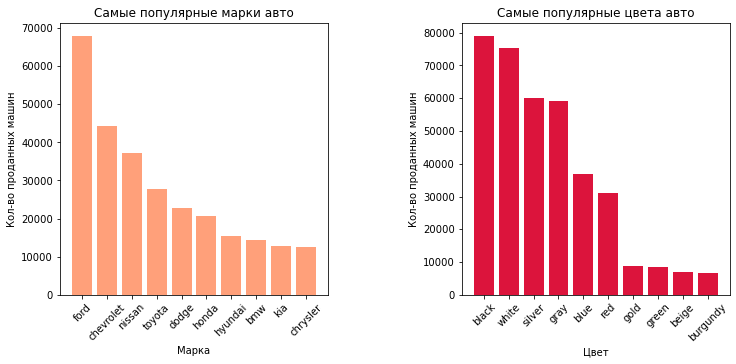

In [30]:
#Устанавливаю размеры фигур
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(12)

#Первый график для марок
ax1 = plt.subplot(1, 2, 1)
plt.bar(most_popular_marks['model'], most_popular_marks['count'], color = 'lightsalmon')
plt.xticks(rotation=45)
plt.title(r'Самые популярные марки авто')
plt.xlabel('Марка')
plt.ylabel('Кол-во проданных машин')


#второй график для цветов 
ax2 = plt.subplot(1, 2, 2)
plt.bar(most_popular_colors['color'], most_popular_colors['count'], color = 'crimson')
plt.xticks(rotation=45)
plt.title(r'Самые популярные цвета авто')
plt.xlabel('Цвет')
plt.ylabel('Кол-во проданных машин')

plt.subplots_adjust(wspace=0.5)

Американцы довольно патриотичны и часто отдают предпочтение отечественных производителям. Также они любят японские и европейские марки. Цвета выбирают довольно стандартные, но многие делают выбор в пользу уникальности и покупают, например, золотые машины.

Теперь я хочу добавить расшифровку штатов. Нашел нужные данные в интернете

In [31]:
#Читаю данные
states = pd.read_excel(r'../Датасеты/states.xlsx')

In [32]:
states.head()

,Name,code,Name.1
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,Idaho,ID,Idaho
3,Iowa,IA,Iowa
4,Alabama,AL,Alabama


In [33]:
#Удаляю пропуски
states = states.dropna()
#Удаляю одну колонку со штатами, т.к там были неотфильрованные значения и они не нужны
del states['Name']

In [34]:
#Переименовываю колонку с расшифровкой
states = states.rename(columns = {'Name.1':'state_name'})
#Меняю расшифроку на нижний регистр, т.к именно такой в исходных данных
states['code'] = states['code'].str.lower()

In [35]:
# Все поулчилось именно так, как я и хотел
states.head()

,code,state_name
2,id,Idaho
3,ia,Iowa
4,al,Alabama
5,ak,Alaska
6,az,Arizona


In [36]:
states.state_name.unique()

array(['Idaho', 'Iowa', 'Alabama', 'Alaska', 'Arizona', 'Arkansas',
       'Wyoming', ' Washington', ' Vermont', ' lth of Virginia',
       ' Wisconsin', ' Hawai`i', ' Delaware', ' Georgia',
       ' West Virginia', ' Illinois', ' Indiana', ' California',
       ' Kansas', ' lth of Kentucky', ' Colorado', ' Connecticut',
       ' Louisiana', ' lth of Massachusetts', ' Minnesota',
       ' Mississippi', ' Missouri', ' Michigan', ' Montana', ' Maine',
       ' Maryland', ' Nebraska', ' Nevada', ' New Hampshire',
       ' New Jersey', ' New York', ' New Mexico', ' Ohio', ' Oklahoma',
       ' Oregon', ' lth of Pennsylvania',
       ' Rhode Island and Providence Plantations', ' North Dakota',
       ' North Carolina', ' Tennessee', ' Texas', ' Florida',
       ' South Dakota', ' South Carolina', ' Utah'], dtype=object)

In [37]:
#Переименовываю некоторые штаты так, чтобы выглядело красивее на графике
states.loc[45,'state_name'] = 'Pennsylvania'
states.loc[22,'state_name'] = 'Kentucky'
states.loc[11,'state_name'] = 'Virginia'
states.loc[27,'state_name'] = 'Massachusetts'


In [38]:
#Соединяю с основными данными 
data1 = data1.merge(states, left_on = 'state', right_on = 'code',how = 'left')

In [39]:
data1.head()

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate,date_parsed,code,state_name
0,2015,kia,Sorento,LX,SUV,automatic,5xyktca69fg566472,ca,5.0,16639.0,white,black,"kia motors america, inc",20500,21500,Tue Dec 16 2014 12:30:00 GMT-0800 (PST),2014-12-16 12:30:00+08:00,ca,California
1,2015,kia,Sorento,LX,SUV,automatic,5xyktca69fg561319,ca,5.0,9393.0,white,beige,"kia motors america, inc",20800,21500,Tue Dec 16 2014 12:30:00 GMT-0800 (PST),2014-12-16 12:30:00+08:00,ca,California
2,2014,bmw,3 Series,328i SULEV,Sedan,automatic,wba3c1c51ek116351,ca,4.5,1331.0,gray,black,financial services remarketing (lease),31900,30000,Thu Jan 15 2015 04:30:00 GMT-0800 (PST),2015-01-15 04:30:00+08:00,ca,California
3,2015,volvo,S60,T5,Sedan,automatic,yv1612tb4f1310987,ca,4.1,14282.0,white,black,volvo na rep/world omni,27500,27750,Thu Jan 29 2015 04:30:00 GMT-0800 (PST),2015-01-29 04:30:00+08:00,ca,California
4,2014,bmw,6 Series Gran Coupe,650i,Sedan,automatic,wba6b2c57ed129731,ca,4.3,2641.0,gray,black,financial services remarketing (lease),66000,67000,Thu Dec 18 2014 12:30:00 GMT-0800 (PST),2014-12-18 12:30:00+08:00,ca,California


Добавил расшифровку, но нужно еще кое-что подправить

In [40]:
#Переименовываю колонку
data1 = data1.rename(columns = {'state_name_y':'state_name'})

In [41]:
#Меняю пропущенные значения на 'N'
data1['state_name'] = data1.state_name.fillna('N')
# Удаляю колонку 'code', т.к она идентична колонке 'state'
del data1['code']

In [42]:
#Проверяю пропущенные значния
data1.isnull().sum()

year            0
make            0
model           0
trim            0
body            0
transmission    0
vin             0
state           0
condition       0
odometer        0
color           0
interior        0
seller          0
mmr             0
sellingprice    0
saledate        0
date_parsed     0
state_name      0
dtype: int64

Все получилось. Теперь хочу создать график, на котором будет видно, в каких штатах совершается болшьше всего продаж.

In [43]:
#Создаю дф, в котором группирую по названию штата и считаю продажи
popular_state = data1[data1['state_name']!='N'].groupby(['state_name'],as_index = False).condition.count()
#Меняю название колонки, в которой отображается количество продаж
popular_state = popular_state.rename(columns = {'condition':'count'})

In [44]:
#Выбираю 10 штатов с самыми большими продажами
popular_state = popular_state.sort_values(by='count',ascending = False).iloc[0:10,:]

In [45]:
popular_state

,state_name,count
2,Florida,57383
0,California,56290
31,Pennsylvania,35842
24,Texas,32485
3,Georgia,24392
15,New Jersey,19177
18,North Carolina,17142
23,Tennessee,16538
5,Illinois,16504
19,Ohio,15346


Text(0, 0.5, 'Кол-во проданных машин')

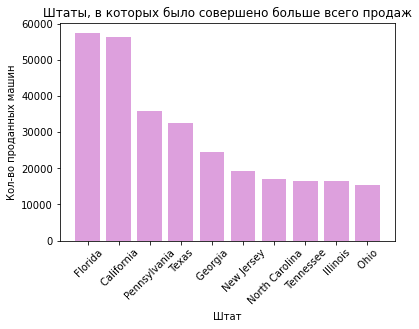

In [46]:
#График 'Штаты, в которых было совершено больше всего продаж'
plt.bar(popular_state['state_name'], height =  popular_state['count'], color = 'plum' )
plt.xticks(rotation=45)
plt.title(r'Штаты, в которых было совершено больше всего продаж')
plt.xlabel('Штат')
plt.ylabel('Кол-во проданных машин')


Больше всего машин было продано во Флориде, Калифорнии и Пенсильвании. Замыкают десятку Огайо, Иллинойс и Теннесси.

Мне стало интересно различаются ли предпочтения к маркам у людей в разных штатах. Для этого я напишу небольшую функцию. Для примера я возьму Техас и Калифорнию



In [47]:
def marks_state(state1, state2):
    #ДФ, в котором стоит фильтр по первому штату. Группирую по марке авто и считаю кол-во продаж
    first_state = data1[data1['state_name'] == state1].groupby(['make'],as_index = False).condition.count()
    #Переименовыаю столбец с количество продаж
    first_state = first_state.rename(columns = {'condition':'count'})
    #Сортирую по количеству продаж в порядке убывания
    first_state = first_state.sort_values(by='count',ascending = False).iloc[0:10,:]
    
    #ДФ, в котором стоит фильтр по второму штату. Группирую по марке авто и считаю кол-во продаж
    second_state = data1[data1['state_name'] == state2].groupby(['make'],as_index = False).condition.count()
    #Переименовыаю столбец с количество продаж
    second_state = second_state.rename(columns = {'condition':'count'})
    #Сортирую по количеству продаж в порядке убывания
    second_state = second_state.sort_values(by='count',ascending = False).iloc[0:10,:]
    
    #Устанавливаю размеры фигур
    fig = plt.figure()
    fig.set_figheight(5)
    fig.set_figwidth(12)
    
    #Визуализация первого графика
    ax1 = plt.subplot(1, 2, 1)
    plt.bar(first_state['make'], first_state['count'], color = 'tan')
    plt.xticks(rotation=90)
    plt.title(f'Самые продаваемые машины в{state1}',fontsize = 12)

    #Визуализация второго графика
    ax2 = plt.subplot(1, 2, 2)
    plt.bar(second_state['make'], second_state['count'], color = 'seagreen')
    plt.xticks(rotation=90)
    plt.title(f'Самые продаваемые машины в{state2}',fontsize = 12)


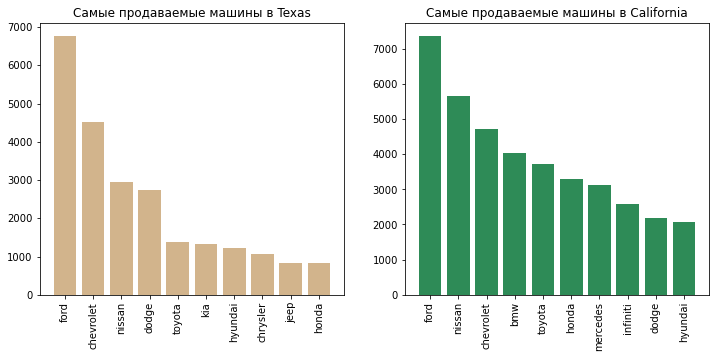

In [48]:
#Вызываю функциб для Техаса и Калифорнии
marks_state(' Texas', ' California')

Предпочтения действительно меняются. В Калифорнии люди гораздо чаще отдают предпочтение премиальным маркам, таким как мерседес, бмв, инфинити. В Техасе же люди предпочитают им более дешевые авто. Однако и там, и там люди любят отечественных производителей 

Теперь я хочу заняться изучением количественных данных.

In [49]:
#Создаю новый ДФ с количественными переменными
quantitative = data1.loc[:,['year', 'odometer', 'condition', 'sellingprice']]

In [50]:
quantitative.head()

,year,odometer,condition,sellingprice
0,2015,16639.0,5.0,21500
1,2015,9393.0,5.0,21500
2,2014,1331.0,4.5,30000
3,2015,14282.0,4.1,27750
4,2014,2641.0,4.3,67000


In [51]:
quantitative.isnull().sum()

year            0
odometer        0
condition       0
sellingprice    0
dtype: int64

In [52]:
quantitative.describe()

,year,odometer,condition,sellingprice
count,400000.000000,400000.000000,400000.000000,400000.000000
mean,2009.796108,70504.438820,3.309471,13187.522913
std,4.042418,54534.121344,1.108808,9472.330671
min,1982.000000,0.000000,0.000000,1.000000
25%,2007.000000,28876.750000,2.600000,6300.000000
50%,2011.000000,54848.000000,3.500000,11900.000000
75%,2013.000000,102891.000000,4.200000,17800.000000
max,2015.000000,999999.000000,5.000000,230000.000000


In [53]:
quantitative.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400000 entries, 0 to 399999
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          400000 non-null  int64  
 1   odometer      400000 non-null  float64
 2   condition     400000 non-null  float64
 3   sellingprice  400000 non-null  int64  
dtypes: float64(2), int64(2)
memory usage: 15.3 MB


С типами данных все хорошо

Есть значения, которые равны 0. Я думаю, что это выбросы, поэтому надо от них избавиться.

In [54]:
#Фильтрую ненулевые значения
quantitative = quantitative[(quantitative['sellingprice'] > 0) & (quantitative['odometer'] > 0) & (quantitative['condition'] > 0)]

Теперь я хочу рассчитать корреляцию между различными факторами

Text(33.0, 0.5, 'Показатели авто')

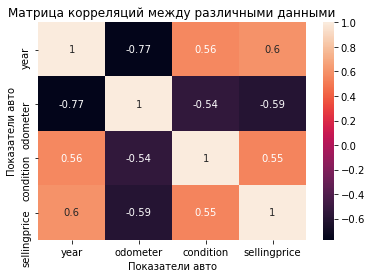

In [75]:
correlation_matrix = quantitative.corr()

sns.heatmap(correlation_matrix, annot = True)

plt.title("Матрица корреляций между различными данными")

plt.xlabel("Показатели авто")

plt.ylabel("Показатели авто")



Высокая отрицательная корреляция была найдена между пробегом и годом выпуска, что довольно логично. Это означает, что с увеличением пробега, уменьшается цена

Состояние авто коррелирует с ценой продажи и с годом выпуска, но не сильно. Коэффициент корреляции Спирмена показал среднее значение 



<ipython-input-55-760b9b849ce0>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(xlabels);
<ipython-input-55-760b9b849ce0>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(ylabels);


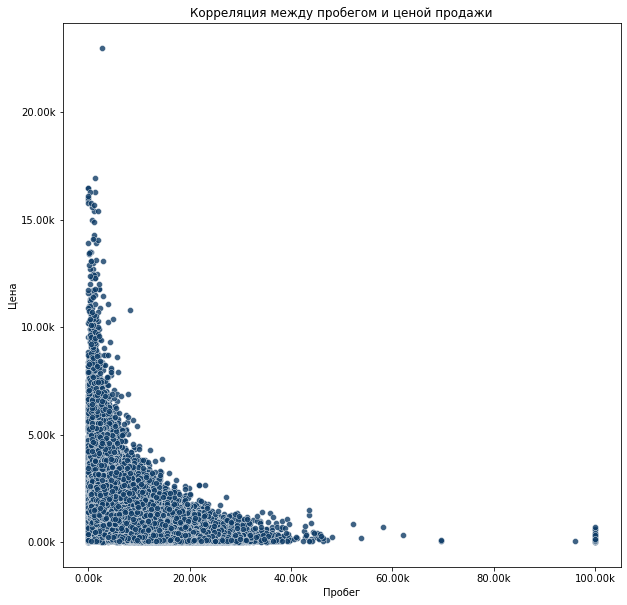

In [55]:
plt.figure(figsize=(10,10))
g=sns.scatterplot(x=quantitative['odometer'],y=quantitative['sellingprice'],data=data,color='#0d3b66',alpha=0.8)
g.set_title('Корреляция между пробегом и ценой продажи',fontsize=12)
g.set_xlabel('Пробег',fontsize=10)
g.set_ylabel('Цена',fontsize=10)
xlabels=['{:,.2f}'.format(x)+'k' for x in g.get_xticks()/10e3]
ylabels=['{:,.2f}'.format(y)+'k' for y in g.get_yticks()/10e3]
g.set_xticklabels(xlabels);
g.set_yticklabels(ylabels);

Видно, что, хотя увеличение значений одометра (> 45k) привело к снижению продажной цены автомобилей, были автомобили, у которых были более низкие значения одометра, но их отпускная цена осталась < 5k. Таким образом, мы смогли понять, что не только значение одометра, но и другие факторы, такие как марка, модель, состояние и т.д, Сыграли важную роль в принятии решения о продажной цене автомобилей.

Далее я хочу посмотреть на то, сколько авто было продано в каждом году с 1982.

In [59]:
#Создаю дф, в котором группирую по году и считаю количество продаж
year_count = data1[data1['make']!='N'].groupby(['year'],as_index = False).condition.count()
year_count = year_count.rename(columns = {'condition': 'count'})

In [60]:
#Проверяю
year_count.year.unique()


array([1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992,
       1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003,
       2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014,
       2015], dtype=int64)

Все хорошо

Text(0.5, 0, 'Год')

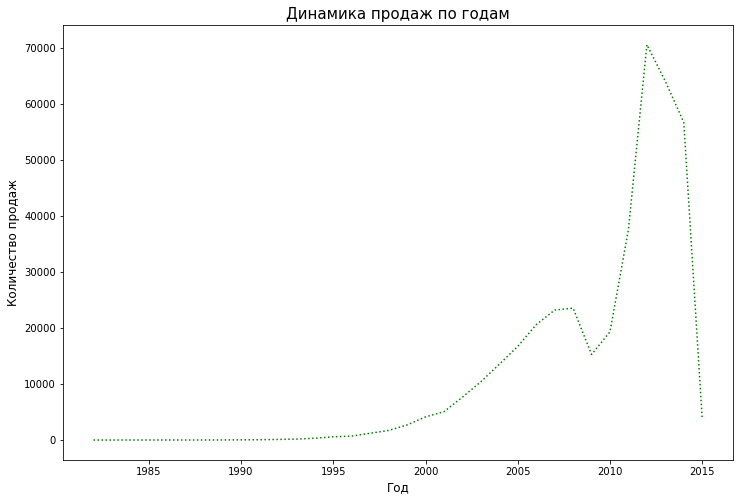

In [61]:
#Визуалзирую
fig = plt.figure()

fig.set_figheight(8)
fig.set_figwidth(12)
plt.plot(year_count['year'], year_count['count'],color = 'green', linestyle = ':')
plt.title(f"Динамика продаж по годам", size = 15)
plt.ylabel('Количество продаж', size = 12)
plt.xlabel('Год', size = 12)

Пиковые продажи были в 2012 году, после чего пошел спад. Интересно, что там было 

In [62]:
# решил немного оптимизировать процесс и написать функци по сзданию дф и графиков
def df_report(df_name, year,df_model, df_state, df_color):
    df_name = data1.copy()
    #фильтр по входному году
    df_name = df_name[df_name['year'] == year]
    #выбираю только нужные колонки
    df_name = df_name.loc[:,['year', 'make', 'state_name', 'color']]
    
    #Группирую по марке авто и считаю количество продаж, сортирую в порякде убывания
    df_model = df_name[df_name['make']!='n'].groupby(['make'],as_index = False).year.count().sort_values(by = 'year', ascending = False).head(10)
    #Группирую по штату и считаю количество продаж, сортирую в порякде убывания
    df_state = df_name[df_name['state_name']!='n'].groupby(['state_name'],as_index = False).year.count().sort_values(by = 'year', ascending = False).head(10)
    #Группирую по цвету и считаю количество продаж, сортирую в порякде убывания
    df_color = df_name[df_name['color']!='N'].groupby(['color'],as_index = False).year.count().sort_values(by = 'year', ascending = False).head(10)
    
    #устанавливаю размер фигуры
    fig = plt.figure()
    fig.set_figheight(5)
    fig.set_figwidth(7)
    
    #1 график для марки
    ax1 = plt.subplot(2, 2, 1)
    plt.bar(df_model['make'], df_model['year'], color = 'steelblue')
    plt.xticks(rotation=90)
    plt.title(f'Количество проданных марок в {year} г.',fontsize = 10)

    #2 график для цвета
    ax2 = plt.subplot(2, 2, 2)
    plt.bar(df_color['color'], df_color['year'], color = 'lightslategrey')
    plt.xticks(rotation=90)
    plt.title(f'Самые распространенные цвета в {year} г.',fontsize = 10)

    #3 график для штата
    ax3 = plt.subplot(2, 1, 2)
    plt.bar(df_state['state_name'], df_state['year'], color = 'teal')
    plt.xticks(rotation=90)
    plt.title(f'Штаты, в которых было больше всего продаж в {year} г.',fontsize = 10)
    plt.subplots_adjust(hspace=1, wspace = 0.5)

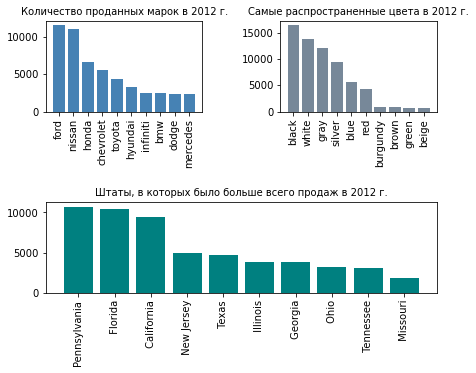

In [63]:
df_report('cars2012',2012,'model2012','state2012','color2012')


Исходя из этих данных, я не заметил ничего необычного. Например, Пенсильвания, Флорида и Калифорния являются самыми популярными штатами и в 2012 году, и в целом за все время. Примерно такая же ситуация обстоит и с автомобильными марками, однако в этом году самой популярным производителем стал "Ниссан", а не "Форд"

Для сравнения, можно взять 2010 год, т.к в это время наблюдалась просадка по продажам, а так же 2013 г, т.к в это время начался резкий спад после пика.

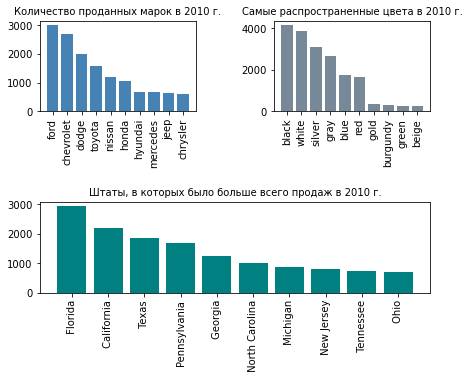

In [64]:
df_report('cars2010',2010,'model2010','state2010','color2010')

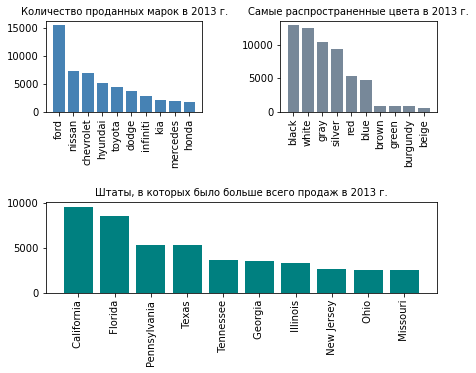

In [65]:
df_report('cars2013',2013,'model2013','state2013','color2013')

Анализ качественных данных не дал особых результатов. Спросом пользуются +- одни те же производители в одних и тех же штатах. Я думаю, что стоит проанализировать количественные показатели в этих годах. Для этого я хочу воспользоваться графиков "Ящик с усами"


In [66]:
def boxplot_price(year, year2):
    """ Создаю функцию, которая будет рисовать боксплоты по цене в разные года"""
    
    df_name = quantitative.copy()
    #убираю ненулевые знаычения
    df_name = df_name[df_name['sellingprice'] > 0 ]
    #фильтрую по входному первому году
    df_name = df_name[df_name['year'] == year]
    #сортирую по цене
    df_name = df_name.sort_values(by = 'sellingprice')
    
    df_name2 = quantitative.copy()
    #убираю ненулевые значения
    df_name2 = df_name2[df_name2['sellingprice'] > 0 ]
    #фильрую по входному второму году
    df_name2 = df_name2[df_name2['year'] == year2]
    #сортирую по цене
    df_name2 = df_name2.sort_values(by = 'sellingprice')
    
    #устанавливаю размер фигуры
    fig = plt.figure()
    fig.set_figheight(5)
    fig.set_figwidth(12)

    #box-plot для первого входного года
    ax1 = plt.subplot(1, 2, 1)
    plt.boxplot(df_name['sellingprice'])
    plt.xticks(rotation=45)
    plt.title(f'Ящик с усами по цене в {year}')
    plt.ylabel('Цена')
    plt.grid()
    
    #box-plot для второго входного года
    ax2 = plt.subplot(1, 2, 2)
    plt.boxplot(df_name2['sellingprice'])
    plt.xticks(rotation=45)
    plt.title(f'Ящик с усами по цене в {year2}')
    plt.ylabel('Цена')
    plt.grid()


   


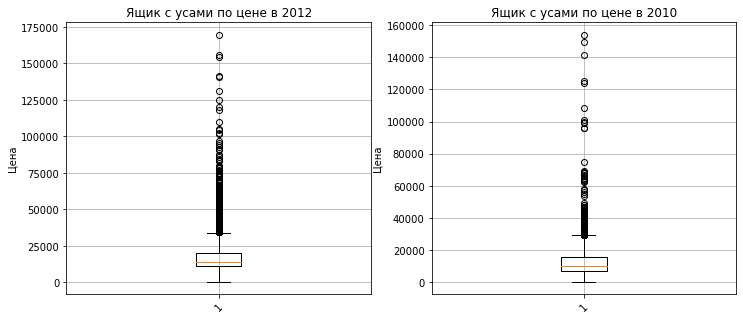

In [67]:
boxplot_price(2012, 2010)

Можно заметить, что различия по цене продаваемых автомобилей минимальны.

In [ ]:
def boxplot_condition(year, year2):
    """ Создаю функцию, которая будет рисовать боксплоты по состоянию в разные года. Тут такая же схема, как и в случае с ценой"""
    df_name = quantitative.copy()
    df_name = df_name[df_name['year'] == year]
    df_name = df_name.sort_values(by = 'condition')
    
    df_name2 = quantitative.copy()
    df_name2 = df_name2[df_name2['year'] == year2]
    df_name2 = df_name2.sort_values(by = 'condition')
    
    fig = plt.figure()

    fig.set_figheight(5)
    fig.set_figwidth(12)

    ax1 = plt.subplot(1, 2, 1)
    plt.boxplot(df_name['condition'])
    plt.xticks(rotation=45)
    plt.title(f'Ящик с усами по состоянию в {year} г.')
    plt.ylabel('Цена')
    plt.grid()
    
    ax1 = plt.subplot(1, 2, 2)
    plt.boxplot(df_name2['condition'])
    plt.xticks(rotation=45)
    plt.title(f'Ящик с усами по состоянию в {year2} г.')
    plt.ylabel('Цена')
    plt.grid()

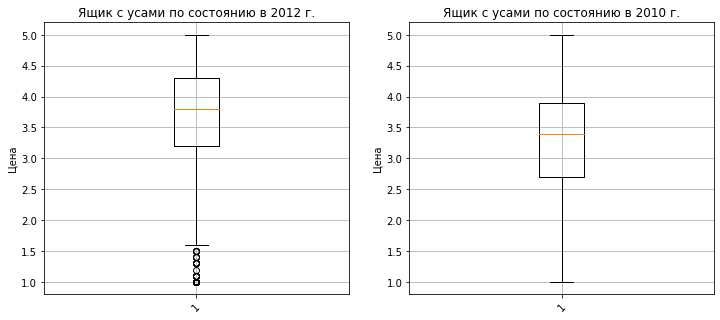

In [69]:
boxplot_condition(2012, 2010)

Исходя из этих диаграмм можно увидеть, что в пиковый год, американцы покупали более хорошие автомобили. Поэтому я считаю, что резкое повышение продаж связано с кризисом 2008 г. в Америке, который вызвал обвал авто рынка.

Подводя итоги хочется сказать, что американцы довольно большое внимание уделяют автомобилям, поэтому было весьма интересно проанализировать эти данные.

Можно сделать вывод, что предпочтения меняются в зависимости от штата, но по всей Америке люди любят отечественных производителей (Форд, Шевроле, Крайслер). 

Автомобильный рынок в США всегда был индикатором экономического здоровья страны, поэтому в кризис продажи резко падают, но с 1985 года видна тенденция устойчивого роста количества продаж. 

